# Setup

In [1]:
%%capture
import scanpy as sc
import scvi
import os
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings

In [18]:
sc.set_figure_params(figsize=(4,4), dpi=80, dpi_save=300, facecolor="white", frameon=False)
plt.rcParams["axes.grid"] = False
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
os.getcwd()

'/home/joe/Repositories/M-cells/code/WT_AireKO_Fezf2_thymus'

# Set up file paths

## demeter

In [4]:
rawDataPath = "/mnt/iacchus/joe/raw_data/"
processedDataPath = "/mnt/iacchus/joe/processed_data/"

## gardner-lab-computer

In [5]:
# rawDataPath = "/mnt/e/Archive/Joe/raw_data/"
# processedDataPath = "/mnt/e/Archive/Joe/processed_data/"

## Methods

### num genes expressed

In [54]:
def plot_total_genes_normalized_expression(
    adata, genotype_list, threshold=0.02, save_path=None, layer="scVI_normalized", cell_type_key="cell_type",
    genotype_key="genotype", cell_type_list=None, *args, **kwargs,
):
    adata_copy = adata[adata.obs[genotype_key].isin(genotype_list)]
    normalized_expression = pd.DataFrame(
        adata_copy.layers[layer],
        index=adata_copy.obs.index,
        columns=adata_copy.var_names
    )
    normalized_expression = np.log1p(normalized_expression)
    adata_copy.obs[f"nGenes_normalized_{threshold}"] = (normalized_expression > threshold).sum(axis=1)

    df = sc.get.obs_df(adata_copy, [f"nGenes_normalized_{threshold}", cell_type_key, genotype_key])
    if cell_type_list is not None:
        df = df[df.cell_type.isin(cell_type_list)]
        df.cell_type.cat.remove_unused_categories(inplace=True)
        df.cell_type.cat.reorder_categories(cell_type_list, inplace=True)
    df.genotype.cat.reorder_categories(genotype_list, inplace=True)
    plt.figure(figsize=(len(cell_type_list)*len(genotype_list)*0.3, 3.5))
    sns.violinplot(
        data=df,
        x=cell_type_key,
        y=f"nGenes_normalized_{threshold}",
        hue=genotype_key,
        inner=None,
        *args, **kwargs
    )
    plt.xticks(rotation=90)
    if save_path is not None:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.show()
    
def plot_total_genes_raw_expression(
    adata, genotype_list, threshold=0.02, genotype_key="genotype",
    cell_type_key="cell_type", cell_type_list=None, save_path=None,
    layer="counts", *args, **kwargs
):
    raw_expression = {}
    for genotype in genotype_list:
        data = adata[adata.obs[genotype_key] == genotype]
        expression = pd.DataFrame(
            data.layers[layer].todense(),
            index=data.obs.index,
            columns=data.var_names
        )
        expression = expression.div(expression.sum(axis=1), axis=0)*10000
        expression = np.log1p(expression)
        expression["cell_type"] = data.obs.cell_type
        expression = expression.groupby("cell_type").mean()
        raw_expression[genotype] = dict((expression > threshold).sum(axis=1))
    
    plotData = pd.DataFrame(raw_expression).T
    plotData = plotData[cell_type_list]
    plotData = plotData.melt()
    plotData["genotype"] = genotype_list*len(plotData.variable.unique())
    
    plt.figure(figsize=(len(cell_type_list)*len(genotype_list)*0.3, 3.5))
    sns.barplot(
        plotData,
        x="variable",
        y="value",
        hue="genotype",
        *args, **kwargs
    )
    plt.xticks(rotation=90)
    if save_path is not None:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.show()

### num TRAs expressed

In [176]:
def fraction_new_TRAs(
    adata, genotype_list, tra_list, threshold=0.02, save_path=None, layer="scVI_normalized",
    cell_type_key="cell_type", cell_type="Aire+", genotype_key="genotype",
    *args, **kwargs,
):
    adata_copy = adata[(adata.obs[genotype_key].isin(genotype_list)) & (adata.obs[cell_type_key] == cell_type)]
    tra_list = [i for i in tra_list if i in adata_copy.var_names]
    normalized_expression = pd.DataFrame(
        adata_copy.layers[layer],
        index=adata_copy.obs.index,
        columns=adata_copy.var_names
    )
    normalized_expression = np.log1p(normalized_expression)
    normalized_expression["genotype"] = adata_copy.obs[genotype_key]
    normalized_expression = normalized_expression.groupby("genotype").mean()
    normalized_expression = (normalized_expression > threshold).T
    normalized_expression = normalized_expression[
        (normalized_expression[genotype_list[0]] == True) &
        (normalized_expression[genotype_list[1]] == False)
    ]
    tras = normalized_expression[normalized_expression.index.isin(tra_list)]
                        
    fig, ax = plt.subplots()

    size = 0.3
    cmap = plt.colormaps["tab20c"]
    outer_colors = cmap([1, 5])
    inner_colors = cmap([3, 7])

    patches = ax.pie(
        [len(tras), len(normalized_expression)-len(tras)],
        radius=1,
        colors=outer_colors,
        wedgeprops=dict(width=size, edgecolor='w'),
        autopct='%1.1f%%',
    )
    ax.legend(loc="best", labels=["TRAs", "non-TRAs"])

    ax.pie(
        [len(tra_list), len(adata_copy.var_names)-len(tra_list)],
        radius=1-size,
        colors=inner_colors,
        wedgeprops=dict(width=size, edgecolor='w'),
        autopct='%1.1f%%',
    )

    ax.set(aspect="equal")
    if save_path is not None:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.show()
    return normalized_expression, tras
    
def TRA_fraction(adata, cell_type_list, genotype_list, tra_list, layer="scVI_normalized", cell_type_key="cell_type", genotype_key="genotype", save_path=None, threshold=0.02, *args, **kwargs):
    tra_list = [i for i in tra_list if i in adata.var_names]
    normalized_expression = pd.DataFrame(
        adata.layers[layer],
        index=adata.obs.index,
        columns=adata.var_names
    )
    normalized_expression = np.log1p(normalized_expression)
    adata.obs[f"nGenes_normalized_{threshold}"] = (normalized_expression > threshold).sum(axis=1)
    # Get num of TSAs expressed above threshold in each cell
    adata.obs[f"nTRAs_normalized_{threshold}"] = (normalized_expression[tra_list] > threshold).sum(axis=1)
    # compute fraction of genes expressed that are TSAs for each cell
    adata.obs["TRA_frac"] = adata.obs[f"nTSAs_normalized_{threshold}"]/adata.obs[f"nGenes_normalized_{threshold}"]
    
    cells = adata[adata.obs[cell_type_key].isin(cell_type_list) & adata.obs[genotype_key].isin(genotype_list)]
    plotData = pd.DataFrame(sc.get.obs_df(cells, ["TRA_frac", genotype_key, cell_type_key]))
    plotData.cell_type.cat.reorder_categories(cell_type_list, inplace=True)
    plotData.genotype.cat.reorder_categories(genotype_list, inplace=True)

    plt.figure(figsize=(len(cell_type_list)*len(genotype_list)*0.3, 4))
    sns.boxplot(
        plotData,
        x="cell_type",
        y="TRA_frac",
        hue="genotype",
        *args, **kwargs
    )
    plt.xticks(rotation=90)
    # plt.axhline(
    #     y = len(tra_list)/adata.shape[1],
    #     color="black",
    #     linestyle="dashed"
    # )
    if save_path is not None:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.show()

## import data

In [73]:
adata = sc.read(f"{processedDataPath}/M_cell/h5ad_files/combined_WT_fezf2KO_aireKO_all_genes.h5ad")
TRAs = set(pd.read_csv("../../Sansom_TSA_Table.csv")["Gene Symbol"])

# Total gene expression

## normalized expression

/tmp/ipykernel_12193/601737403.py:12: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_copy.obs[f"nGenes_normalized_{threshold}"] = (normalized_expression > threshold).sum(axis=1)


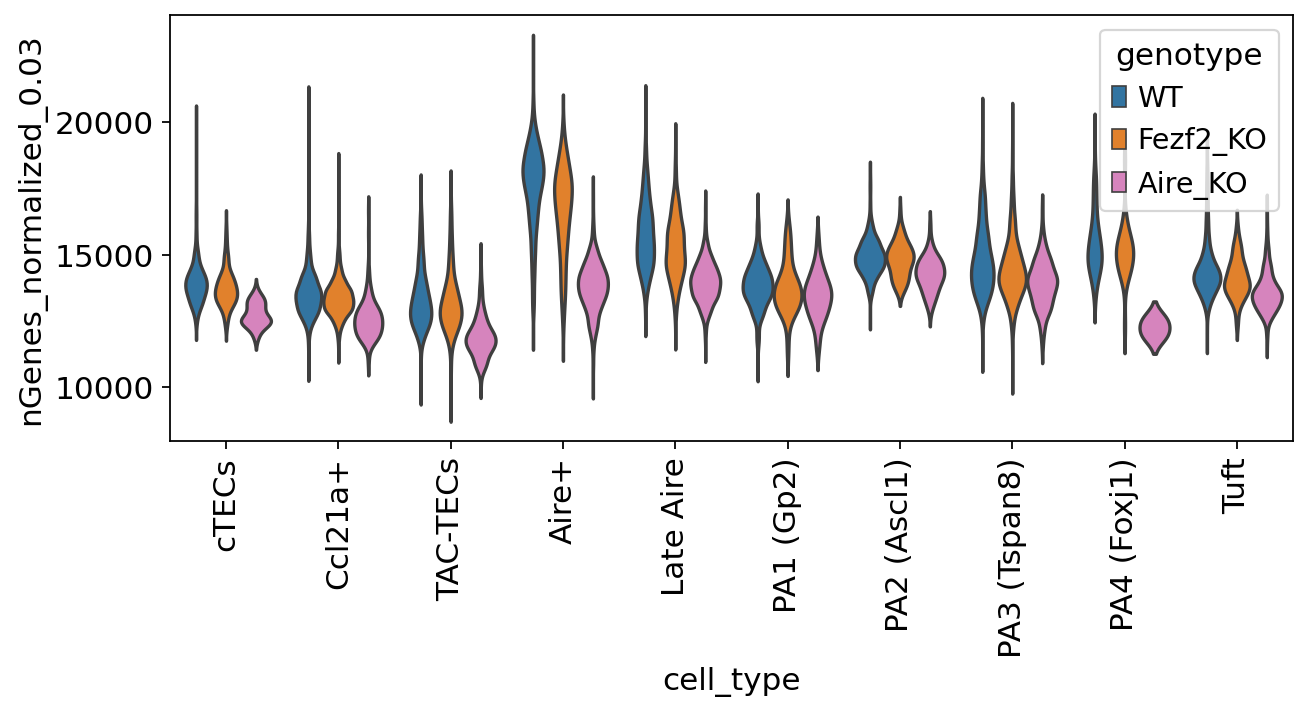

In [139]:
plot_total_genes_normalized_expression(
    adata,
    genotype_list=["WT", "Fezf2_KO", "Aire_KO"],
    cell_type_list=["cTECs", "Ccl21a+", "TAC-TECs", "Aire+", "Late Aire", "PA1 (Gp2)", "PA2 (Ascl1)", "PA3 (Tspan8)", "PA4 (Foxj1)", "Tuft"],
    threshold=0.03,
    save_path=None,
    palette=["tab:blue", "tab:orange", "tab:pink"]
)

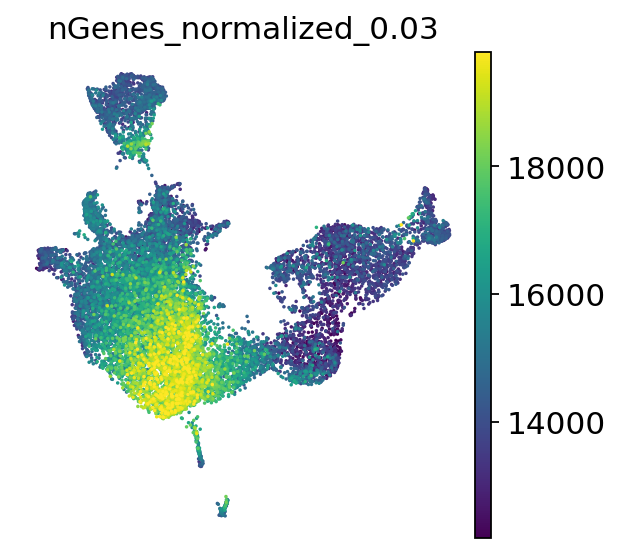

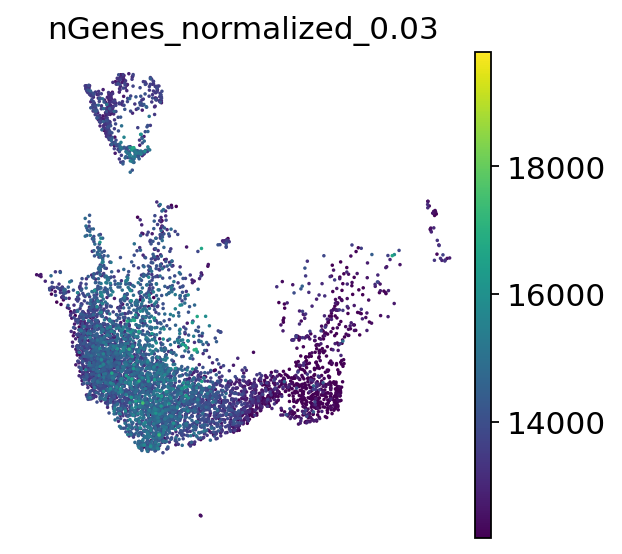

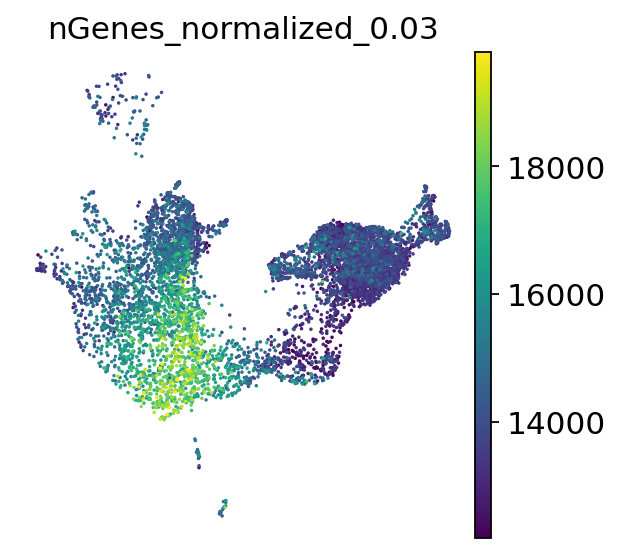

In [168]:
vmin=np.quantile(adata[adata.obs.genotype=="WT"].obs["nGenes_normalized_0.03"], 0.01),
vmax=np.quantile(adata[adata.obs.genotype=="WT"].obs["nGenes_normalized_0.03"], 0.99),
sc.pl.umap(
    adata[adata.obs.genotype=="WT"],
    color="nGenes_normalized_0.03",
    s=10,
    vmin=vmin,
    vmax=vmax,
)
sc.pl.umap(
    adata[adata.obs.genotype=="Aire_KO"],
    color="nGenes_normalized_0.03",
    s=10,
    vmin=vmin,
    vmax=vmax,
)
sc.pl.umap(
    adata[adata.obs.genotype=="Fezf2_KO"],
    color="nGenes_normalized_0.03",
    s=10,
    vmin=vmin,
    vmax=vmax,
)

## Raw counts

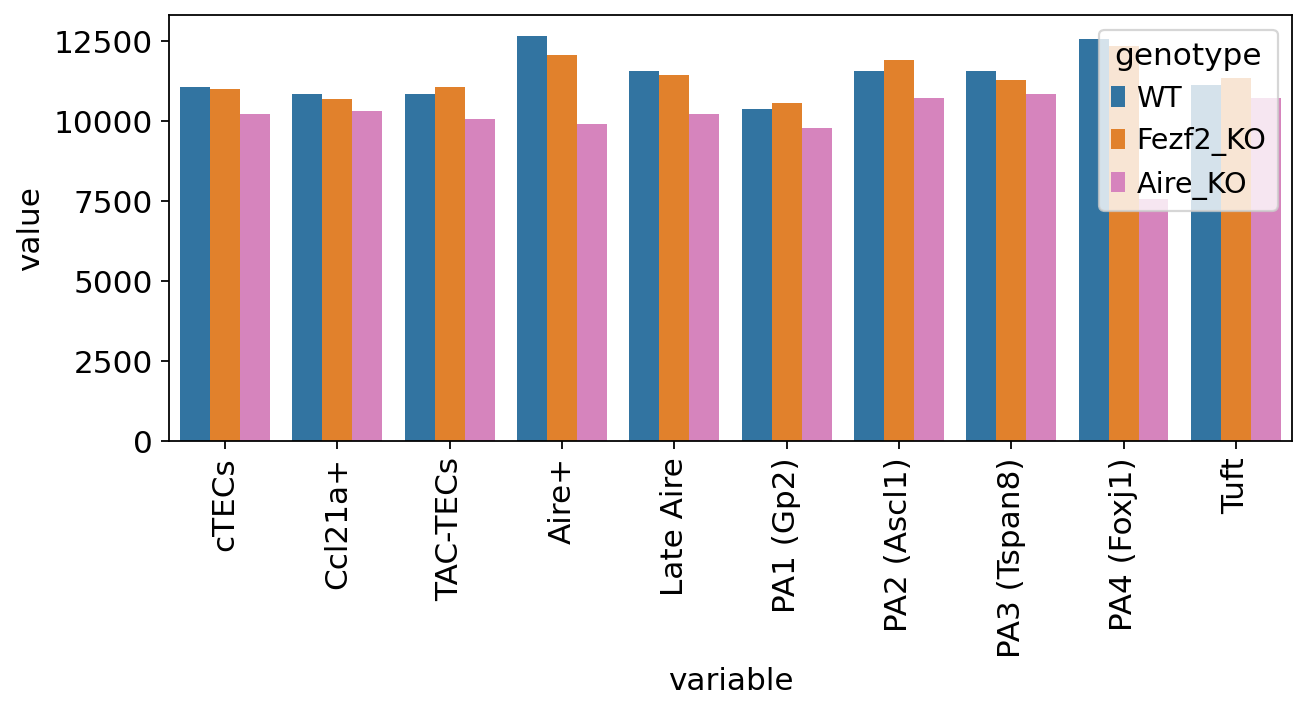

In [138]:
plot_total_genes_raw_expression(
    adata,
    genotype_list=["WT", "Fezf2_KO", "Aire_KO"],
    cell_type_list=["cTECs", "Ccl21a+", "TAC-TECs", "Aire+", "Late Aire", "PA1 (Gp2)", "PA2 (Ascl1)", "PA3 (Tspan8)", "PA4 (Foxj1)", "Tuft"],
    threshold=0.03,
    save_path=None,
    palette=["tab:blue", "tab:orange", "tab:pink"]
)

# TSA expression

## Fraction of new genes expressed in Aire+ cells that are TRAs

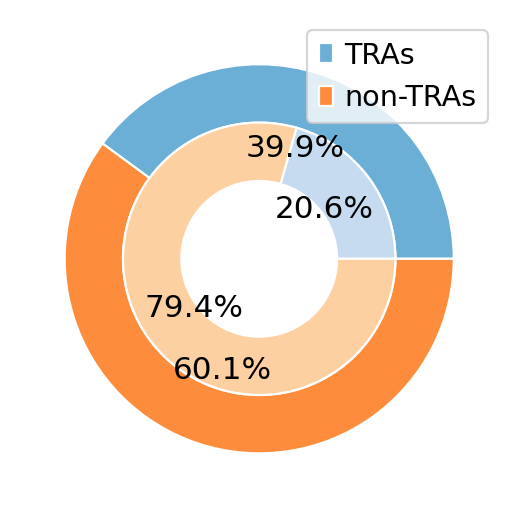

In [163]:
newGenesAire, newTRAsAire = fraction_new_TRAs(
    adata,
    tra_list=TRAs,
    cell_type="Aire+",
    genotype_list=["WT", "Aire_KO"],
    threshold=0.03,
    save_path=None,
)

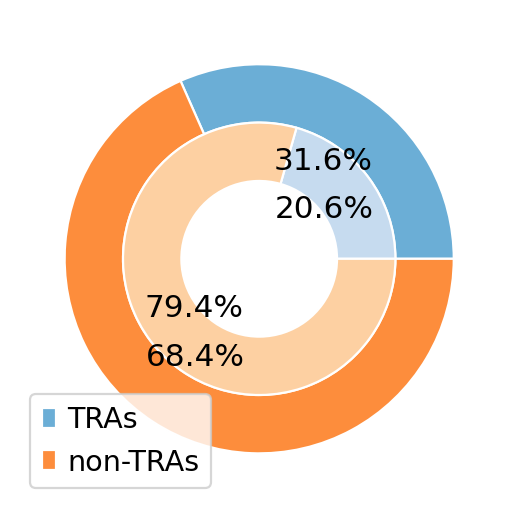

In [161]:
newGenesFezf2, newTRAsFezf2 = fraction_new_TRAs(
    adata,
    tra_list=TRAs,
    cell_type="Aire+",
    genotype_list=["WT", "Fezf2_KO"],
    threshold=0.03,
    save_path=None,
)

## Fraction of all expressed genes that are TRAs

### all cell types

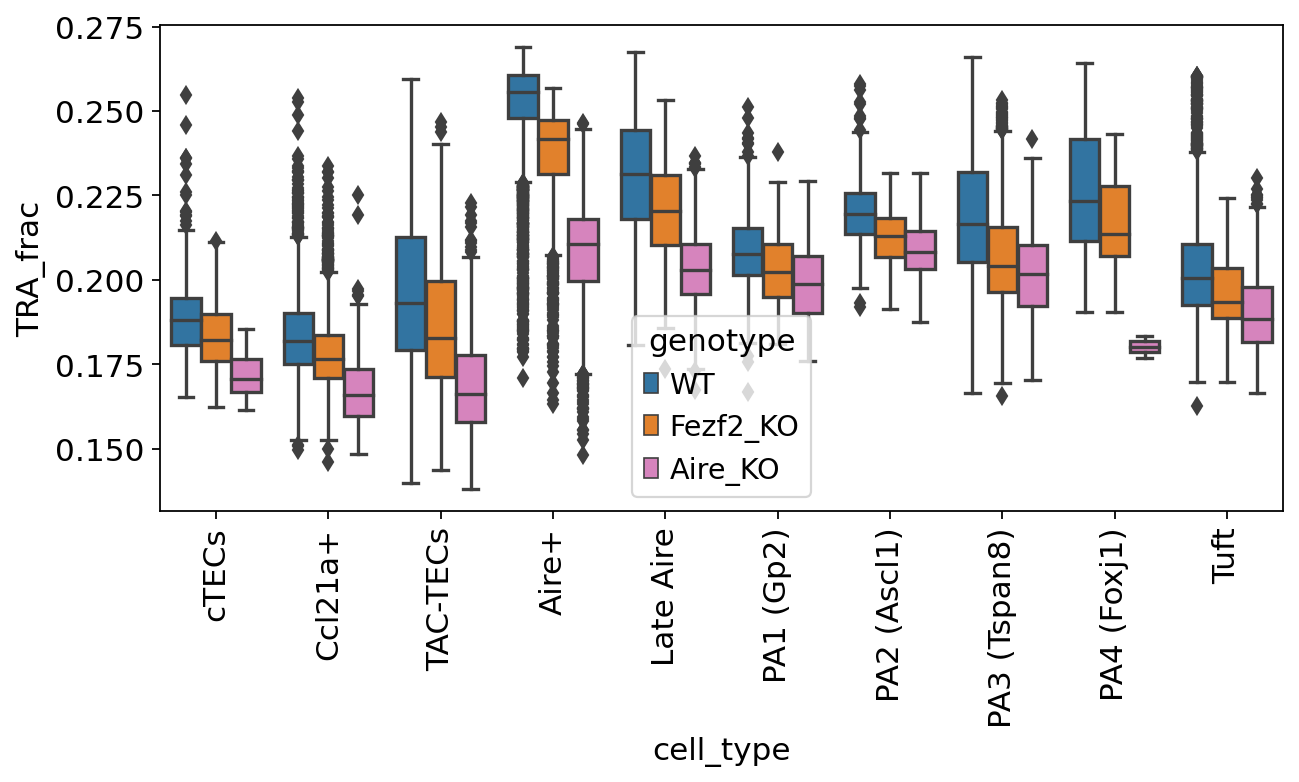

In [177]:
TRA_fraction(
    adata,
    cell_type_list=["cTECs", "Ccl21a+", "TAC-TECs", "Aire+", "Late Aire", "PA1 (Gp2)", "PA2 (Ascl1)", "PA3 (Tspan8)", "PA4 (Foxj1)", "Tuft"],
    tra_list=TRAs,
    genotype_list=["WT", "Fezf2_KO", "Aire_KO"],
    palette=["tab:blue", "tab:orange", "tab:pink"],
    threshold=0.03,
    save_path=None,
)

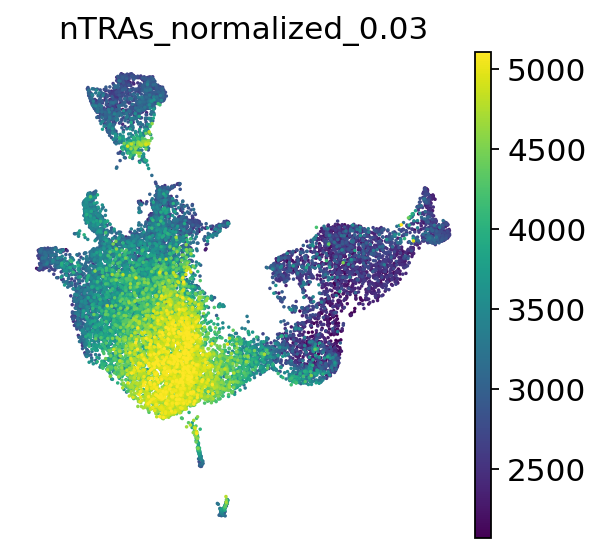

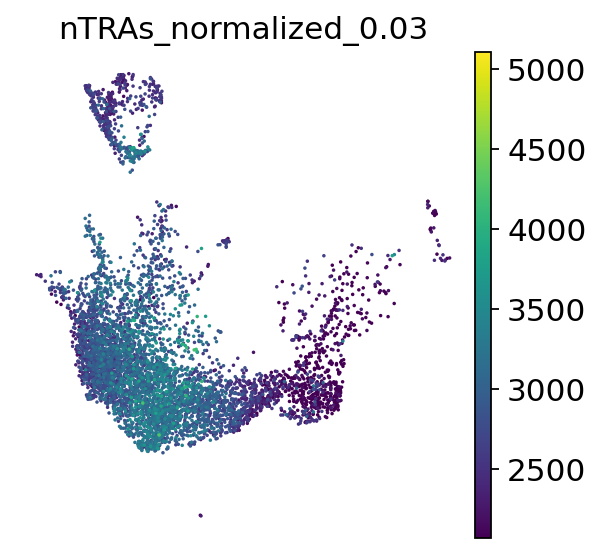

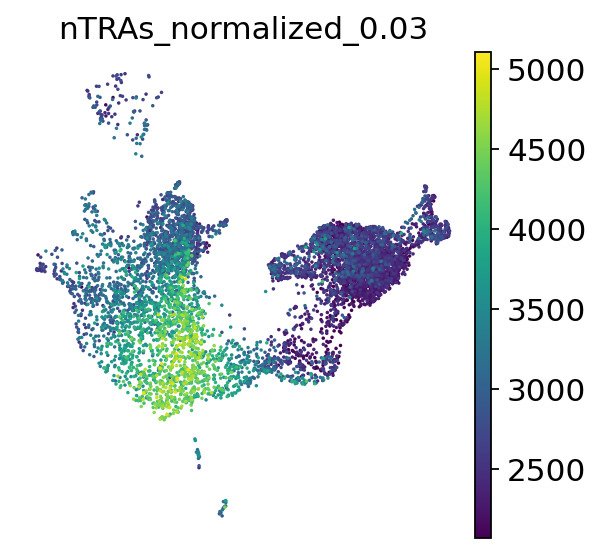

In [174]:
vmin=np.quantile(adata[adata.obs.genotype=="WT"].obs["nTRAs_normalized_0.03"], 0.01),
vmax=np.quantile(adata[adata.obs.genotype=="WT"].obs["nTRAs_normalized_0.03"], 0.99),
sc.pl.umap(
    adata[adata.obs.genotype=="WT"],
    color="nTRAs_normalized_0.03",
    s=10,
    vmin=vmin,
    vmax=vmax,
)
sc.pl.umap(
    adata[adata.obs.genotype=="Aire_KO"],
    color="nTRAs_normalized_0.03",
    s=10,
    vmin=vmin,
    vmax=vmax,
)
sc.pl.umap(
    adata[adata.obs.genotype=="Fezf2_KO"],
    color="nTRAs_normalized_0.03",
    s=10,
    vmin=vmin,
    vmax=vmax,
)

### Subset of cell types

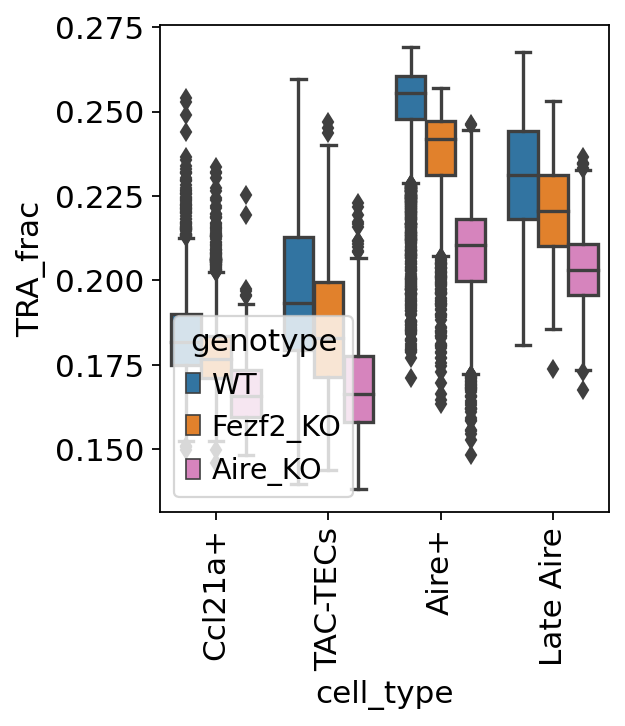

In [178]:
TRA_fraction(
    adata,
    cell_type_list=["Ccl21a+", "TAC-TECs", "Aire+", "Late Aire"],
    tra_list=TRAs,
    genotype_list=["WT", "Fezf2_KO", "Aire_KO"],
    palette=["tab:blue", "tab:orange", "tab:pink"],
    threshold=0.03,
    save_path=None,
)